# OECD TOURISM KPI ANALYSIS

We will conduct an exploratory analysis of tourism data for OECD member countries through 3 KPIs including: **Tourism GDP (direct) as % of total GDP**, **Total tourism employment (direct) as % of total employment**, and **Tourism GVA (direct) as % of total GVA**.

We have chosen this data as it provides a comprehensive overview of tourism's contribution through macroeconomic indicators such as GDP, GVA and employment.

To proceed with the analysis, we will follow these steps:
- I. Data ingestion through the OECD's public API.
- II. Data quality analysis and summary.
- III. Data analysis through the KPIs.
- IV. Analysis of correlations between the KPIs.


# Libraries and Functions

Let's start by importing our libraries and creating our analysis functions.

In [155]:
import pandas as pd
import numpy as np
import pycountry_convert as pc

# Function to retrieve data from OECD API
def get_from_oecd(sdmx_query):
    return pd.read_csv(
        f"https://stats.oecd.org/SDMX-JSON/data/{sdmx_query}?contentType=csv",
        dtype={'Reference Period Code': str, 'Reference Period': str},
        low_memory=False
    )


# Function to retrieve the continent based on the country name 
def get_continent(country):
    try:
        country_code = pc.country_name_to_country_alpha2(country)
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return None

    
# Function to assess data quality and provide a summary
def check_data_quality(df):
    summary = []
    for col in df.columns:
        col_summary = {}
        col_data = df[col]
        
        # Data type
        col_summary['Column'] = col
        col_summary['dtype'] = col_data.dtype
        
        # Number of missing values
        col_summary['missing_values'] = col_data.isnull().sum()
        
        # Number of unique values
        col_summary['unique_values'] = len(col_data.unique())
        
        # Range of values for numerical columns
        if np.issubdtype(col_data.dtype, np.number):
            col_summary['min_value'] = col_data.min()
            col_summary['max_value'] = col_data.max()
            col_summary['mean'] = col_data.mean()
            col_summary['std_dev'] = col_data.std()
        
        # Outliers for numerical columns
        if np.issubdtype(col_data.dtype, np.number):
            lower_bound = col_data.mean() - 3 * col_data.std()
            upper_bound = col_data.mean() + 3 * col_data.std()
            outliers = col_data[(col_data < lower_bound) | (col_data > upper_bound)]
            col_summary['outliers'] = outliers.tolist()
        
        # Duplicates
        col_summary['duplicates'] = df.duplicated(subset=[col]).sum()
        
        summary.append(col_summary)
    
    return pd.DataFrame(summary)

# Function to plot a selected KPI over the years for each country grouped by continent
def plot_country_by_continent(df):
    kpi =  df['Key indicator'].unique()[0]

    # Create a figure and axes for each unique continent
    fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

    # Iterate over each unique continent
    for ax, (continent, data_continent) in zip(axs.flatten(), df.groupby('Continent')):
        # Iterate over each country in the continent
        for country, data_country in data_continent.groupby('Country'):
            # Plot the evolution of values over years for each country
            ax.plot(data_country['YEAR'], data_country['Value'], label=None)
            # Add the country name on the last year
            ax.annotate(country, xy=(data_country['YEAR'].iloc[-1], data_country['Value'].iloc[-1]), xytext=(5, 5), textcoords='offset points', fontsize=8, color='blue')

        # Add titles for each subplot
        ax.set_title(continent)

    # Add global titles
    fig.suptitle(f'{kpi} :  Evolution of values over years', fontsize=16)

    # Display the plot
    plt.tight_layout()
    plt.show()

# Function to plot all KPIs for a specified country over the years.
def plot_country_indicators(df, country):
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Select data for the specific country
    data_country = df[df['Country'] == country]

    # Iterate over each unique key indicator for the country
    for key_indicator in data_country['Key indicator'].unique():
        # Select data for the specific key indicator
        data_key_indicator = data_country[data_country['Key indicator'] == key_indicator]
        
        # Plot the evolution of values over years for the specific key indicator
        ax.plot(data_key_indicator['Year'], data_key_indicator['Value'], label=key_indicator)

    # Add titles and a legend
    ax.set_title(f'Evolution of values over years for each key indicator - {country}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Value')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Display the plot
    plt.grid(True)
    plt.show()


# I. Data Ingestion through the OECD's Public API

Here we will use our first function `get_from_oecd` to retrieve data via the API. The special feature of this method is that the data will be automatically updated with each API call.
Then we will create another column called `Continent` through the function `get_continent` which will represent the respective continent for each member country.


In [156]:
# Initialize the query for the API
tourism_KPI_query = "TOURISM_KEY_IND_PC/all"
# Retrieve data using the function
df_KPI = get_from_oecd(tourism_KPI_query)
# Add a Continent column based on the COUNTRY column
df_KPI['Continent'] = df_KPI['COUNTRY'].apply(get_continent)

# II. Data Quality Analysis and Summary

Here we will use our function called **check_data_quality** which takes our dataframe `df_KPI` as input to generate the result below.


In [153]:
check_data_quality(df_KPI)

,Column,dtype,missing_values,unique_values,duplicates,min_value,max_value,mean,std_dev,outliers
0,COUNTRY,object,0,54,1140,NaN,NaN,NaN,NaN,NaN
1,Country,object,0,54,1140,NaN,NaN,NaN,NaN,NaN
2,KEY_IND_PC,object,0,3,1191,NaN,NaN,NaN,NaN,NaN
3,Key indicator,object,0,3,1191,NaN,NaN,NaN,NaN,NaN
4,YEAR,int64,0,14,1180,2008.000,2021.000,2014.205193,3.690990,[]
5,Year,int64,0,14,1180,2008.000,2021.000,2014.205193,3.690990,[]
6,Unit Code,object,0,1,1193,NaN,NaN,NaN,NaN,NaN
7,Unit,object,0,1,1193,NaN,NaN,NaN,NaN,NaN
8,PowerCode Code,int64,0,1,1193,0.000,0.000,0.000000,0.000000,[]
9,PowerCode,object,0,1,1193,NaN,NaN,NaN,NaN,NaN


In [166]:
df_KPI["Key indicator"].unique()

array(['Tourism GDP (direct) as % of total GDP',
       'Total tourism employment (direct) as % of total employment',
       'Tourism GVA (direct) as % of total GVA'], dtype=object)

In [165]:
df_KPI[df_KPI["Value"].isna()]

,COUNTRY,Country,KEY_IND_PC,Key indicator,YEAR,Year,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags,Continent
935,NZL,New Zealand,KEYIND_TOURGVAPC,Tourism GVA (direct) as % of total GVA,2021,2021,PC,Percentage,0,Units,NaN,NaN,NaN,P,Provisional value,Oceania


# Data Quality and Summary Interpretation

As shown in the table below, the dataframe lists various characteristics of the columns in our OECD member countries' tourism KPI dataset. These details include data type, number of missing values, number of unique values, and number of duplicated values per column. Additionally, statistical information is provided for columns of integer and decimal types.

Here are the key takeaways:

- Data collection spans from 2008 to 2021.
- There are 54 different OECD member countries distributed across 6 continents.
- We are observing 3 KPIs: **'Tourism GDP (direct) as % of total GDP', 'Total tourism employment (direct) as % of total employment', and 'Tourism GVA (direct) as % of total GVA'**.
- There is one country listed that does not have any values in the `Value` column: New Zealand.
- All countries have been accurately classified in our new `Continent` column.


# III. Data Analysis by KPIs

Now let's analyze the data across the 3 different KPIs. To do this, we will divide our dataframe into 3 separate dataframes based on the corresponding KPI. Next, we will display the graphical analysis using our function `plot_country_by_continent`. This analysis will show the evolution of the tourism contribution percentage over the years of observation for the 3 KPIs.


In [168]:
# Split the dataframe into 3 dataframes based on the 3 KPIs
df_KPI_GDP =  df_KPI[df_KPI['Key indicator'] == "Tourism GDP (direct) as % of total GDP"]
df_KPI_GVA =  df_KPI[df_KPI['Key indicator'] == "Tourism GVA (direct) as % of total GVA"]
df_KPI_TTE =  df_KPI[df_KPI['Key indicator'] == "Total tourism employment (direct) as % of total employment"]

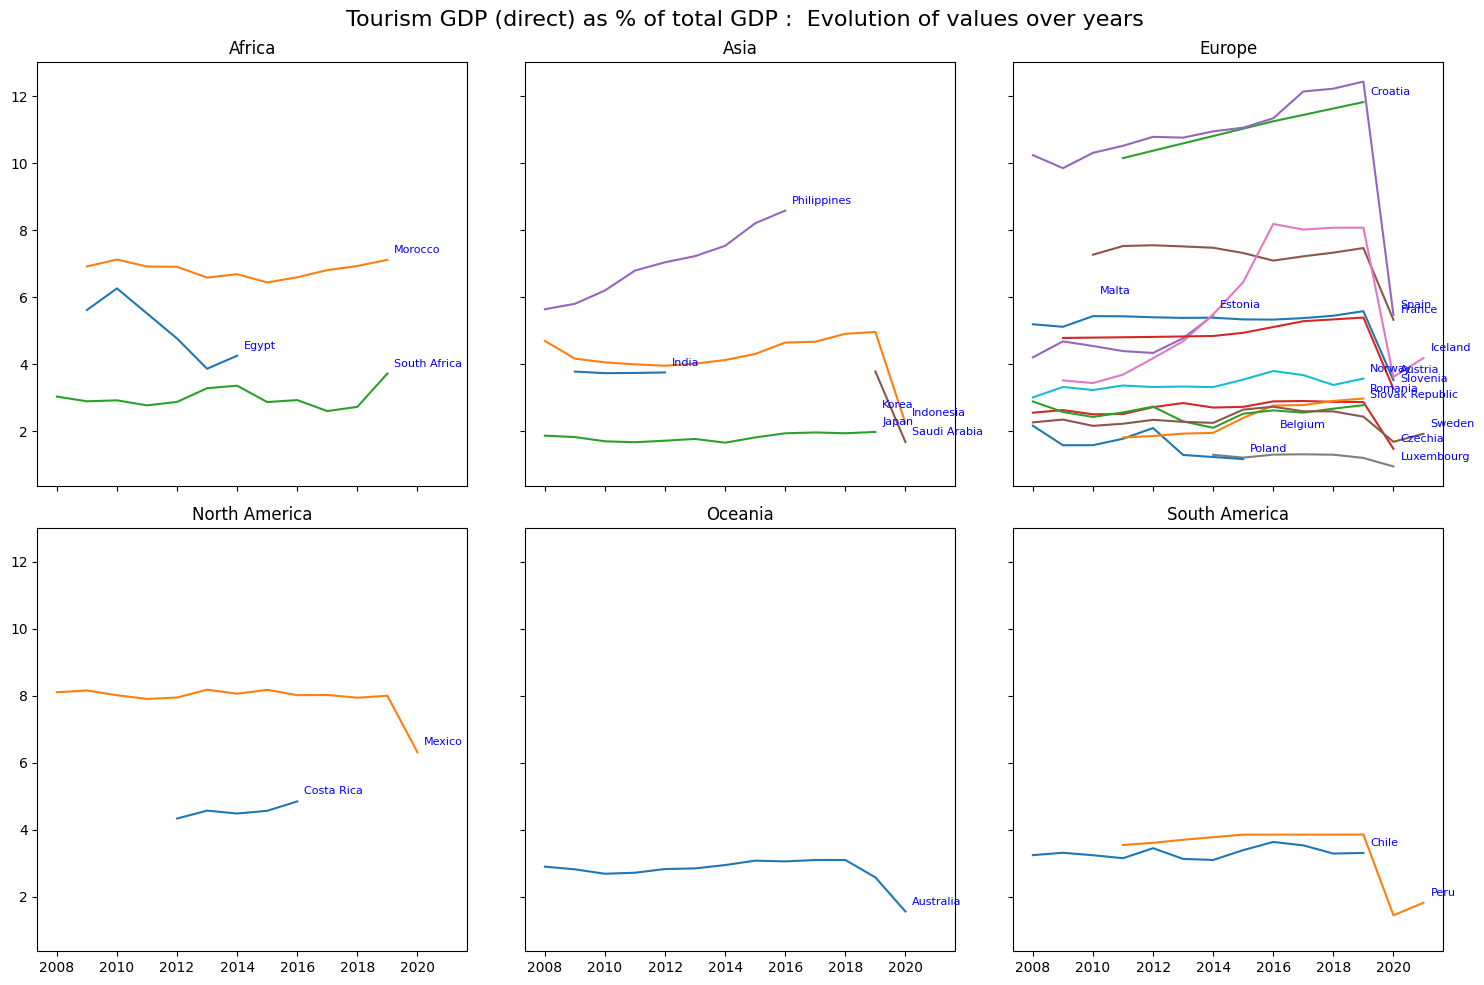

In [169]:
plot_country_by_continent(df_KPI_GDP)

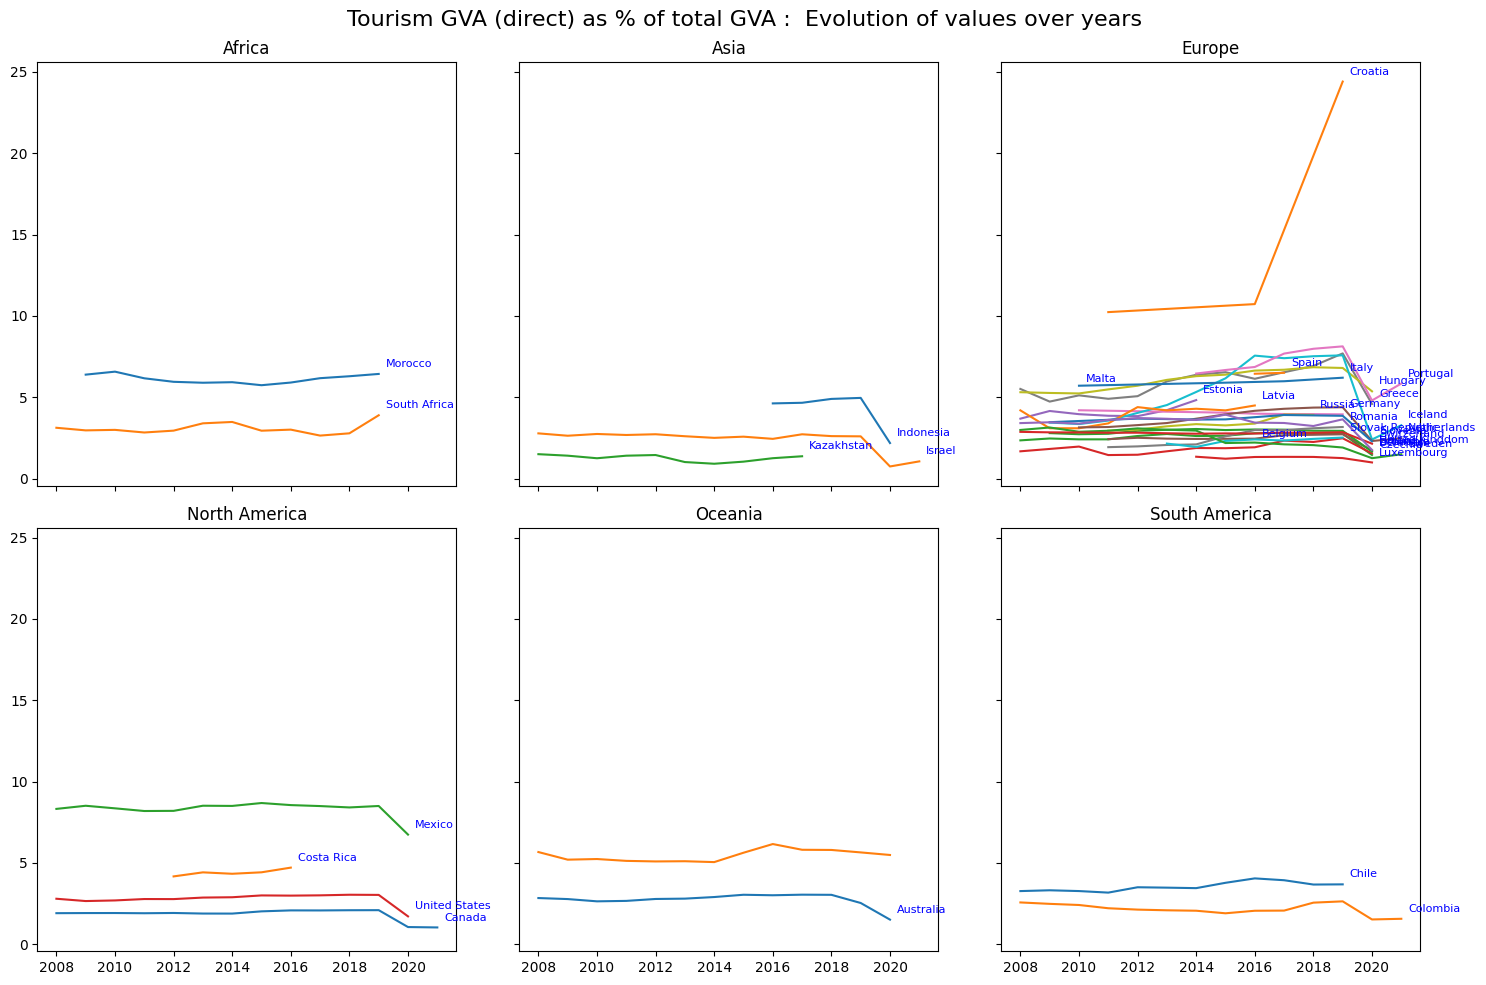

In [170]:
plot_country_by_continent(df_KPI_GVA)

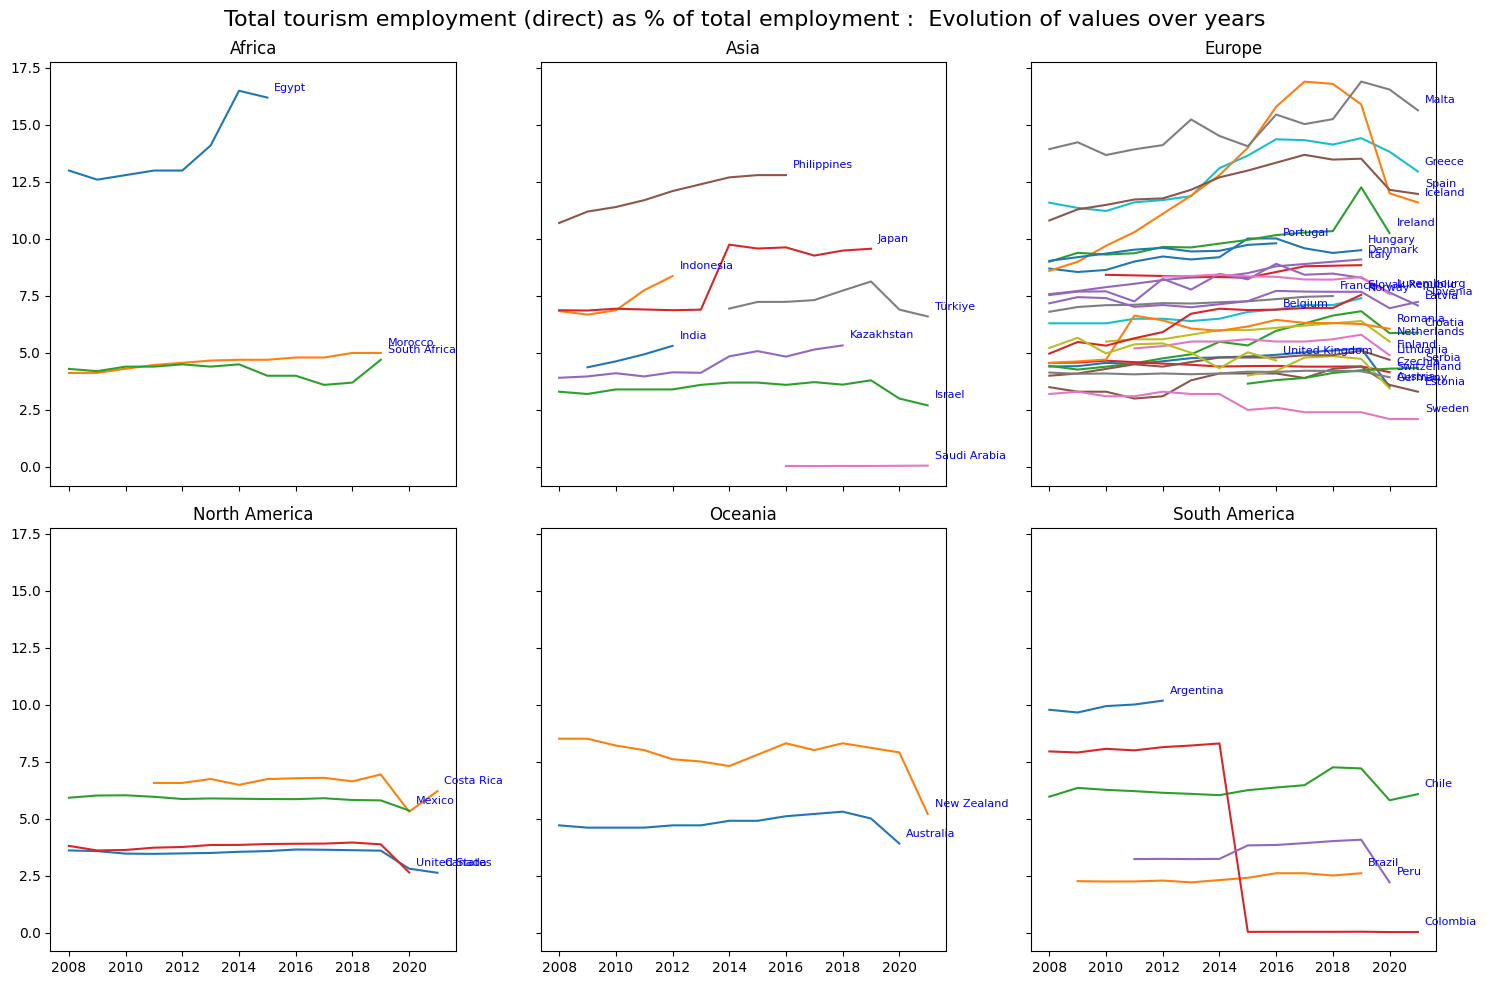

In [171]:
plot_country_by_continent(df_KPI_TTE)

# Interpretation of the 3 Graphs:

- Most member countries come from Europe.
- For the majority of countries, the share of tourism across the 3 different KPIs in their economy is generally less than 10%.
- A significant decrease in all 3 KPIs is observed after 2019, likely due to the crisis caused by Covid-19.

**Tourism GDP (direct) as % of total GDP:**
- Croatia and Spain are the only two countries with a contribution of over 10% to GDP during the analyzed period.
- Strong growth was observed for the Philippines and France during certain periods.

**Tourism GVA (direct) as % of total GVA:**
- Croatia stands out compared to all other member countries with a peak value of over 24% in 2019.
- Most countries have a GVA contribution of less than 8%.

**Total tourism employment (direct) as % of total employment:**
- Unlike the previous KPIs, employment generated by the tourism sector still involves a considerable portion of the active population in several countries. Notably countries such as Egypt, the Philippines, Malta, Greece, Spain and Iceland have a significant share of employment. It is interesting to note that in these countries, the share of employment is quite high but does not significantly affect the contribution to GDP and GVA.

Although there is a relationship between GDP and GVA according to the formula **GVA = GDP + subsidies on products – taxes on products**, it is interesting to see the correlation between these 3 different metrics.


# IV. Analysis of Correlations between the KPIs

This is a simple analysis through the graphs. To do this, we will take examples of countries to display the 3 KPIs simultaneously. We will use our function called `plot_country_indicators`.


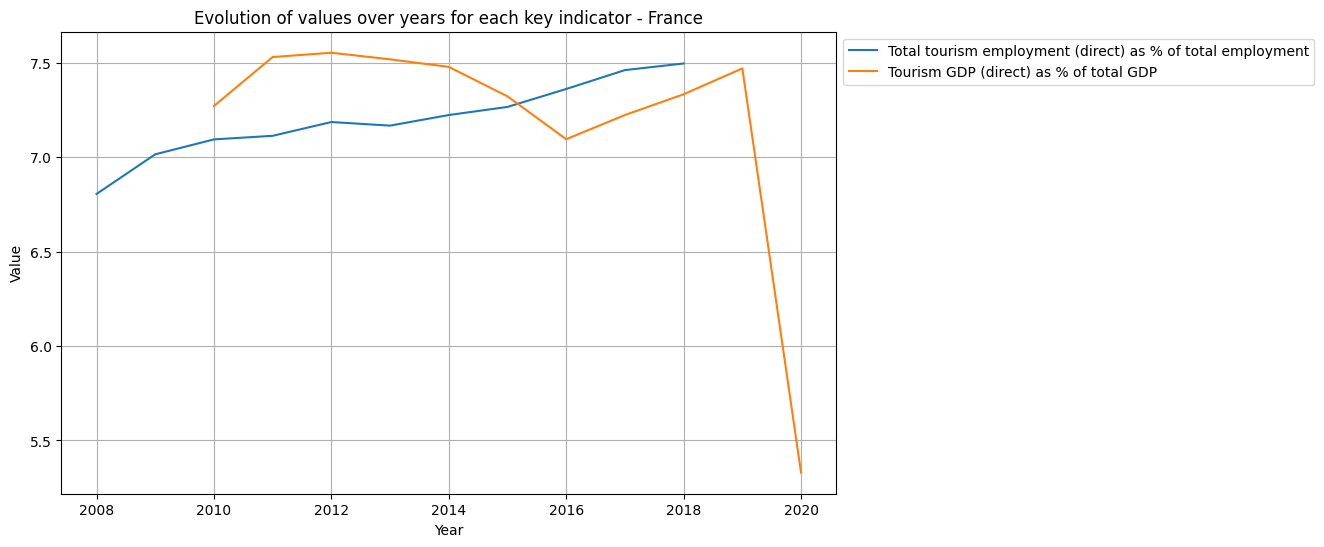

In [178]:
# Lets take France
plot_country_indicators(df_KPI, 'France')

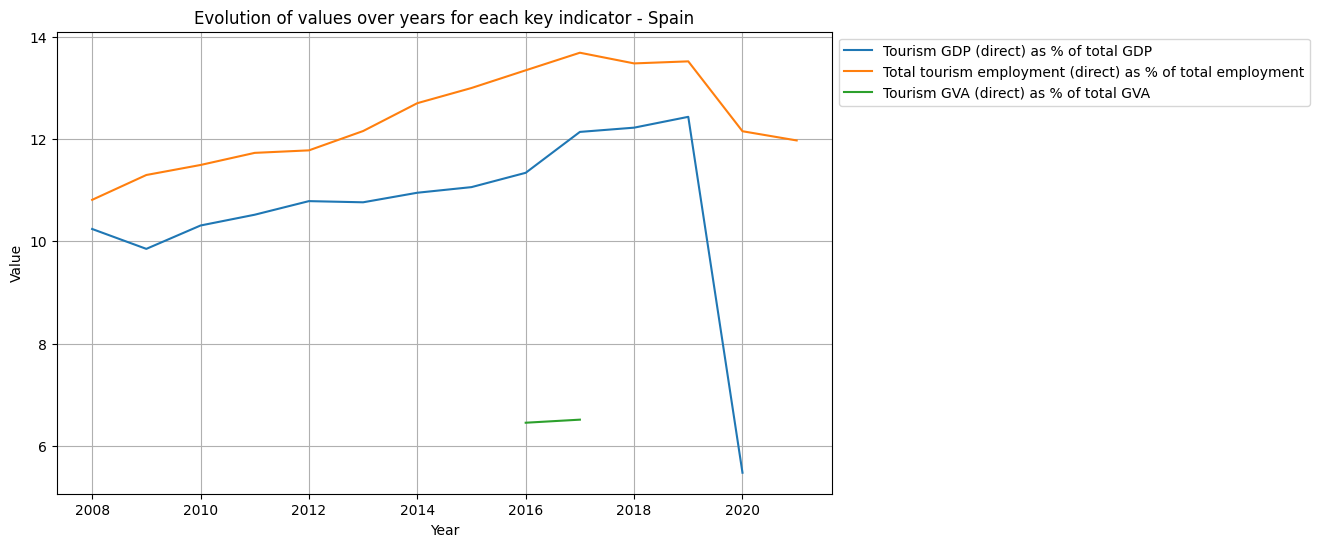

In [179]:
# Lets take Spain
plot_country_indicators(df_KPI, 'Spain')

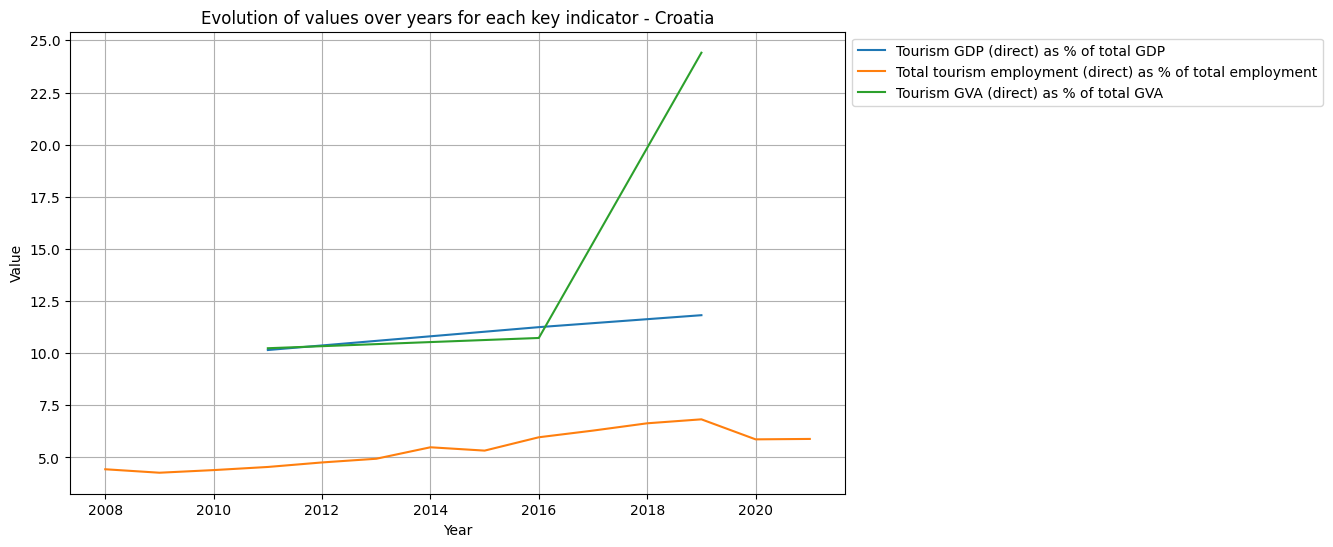

In [180]:
# Lets take Croatia
plot_country_indicators(df_KPI, 'Croatia')

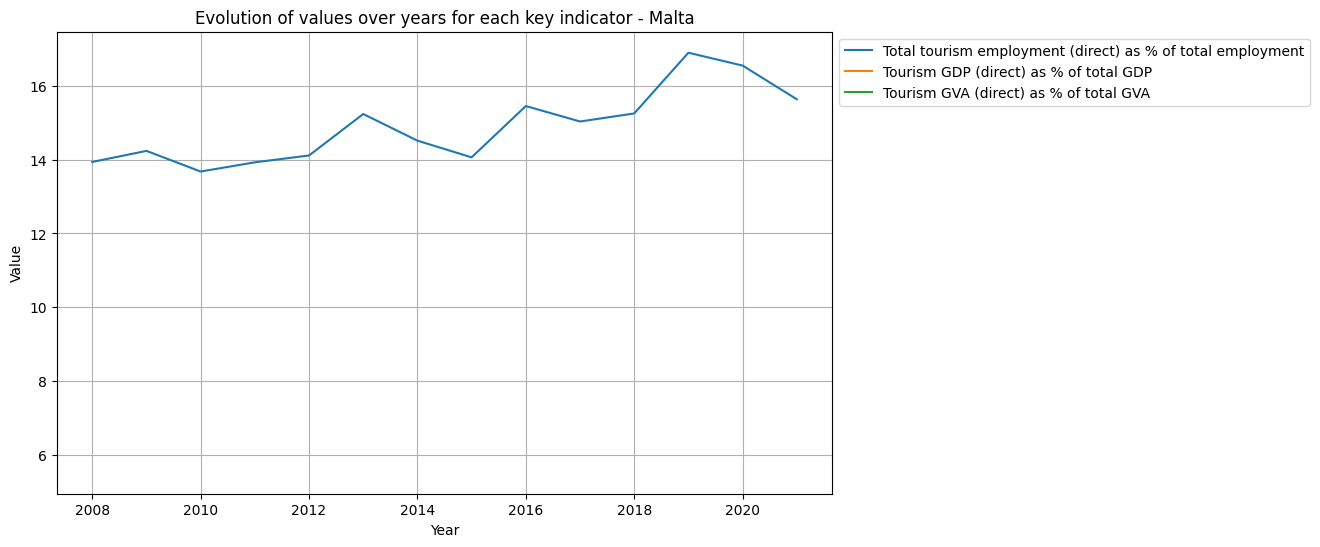

In [181]:
# Lets take Malta
plot_country_indicators(df_KPI, 'Malta')

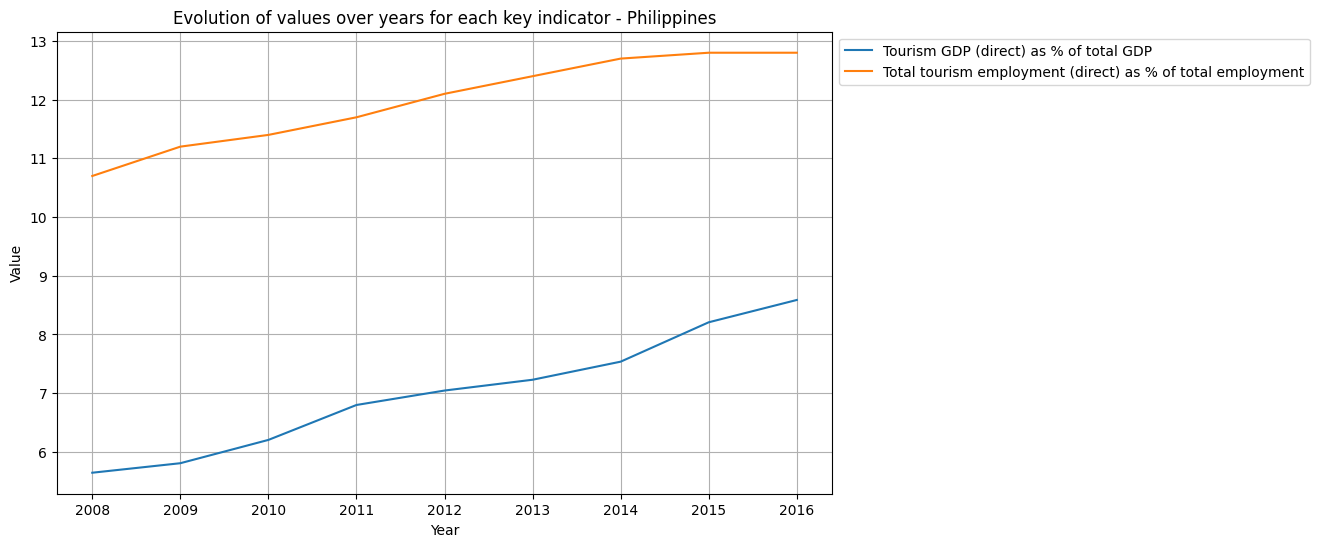

In [182]:
# Lets take Philippines
plot_country_indicators(df_KPI, 'Philippines')

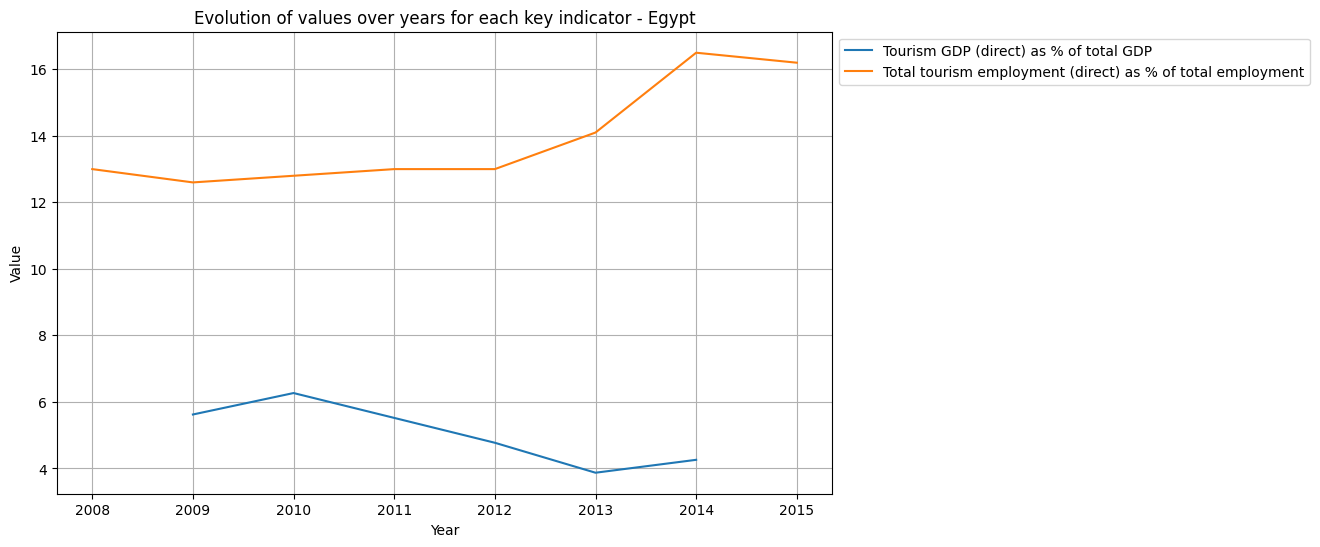

In [183]:
# Lets take Egypt
plot_country_indicators(df_KPI, 'Egypt')

# Interpretation of the Correlation:

As we can see from the few examples of countries we have taken, no conclusion can be drawn at the moment regarding the correlation between the 3 KPIs. We can observe a significant lack of data; we rarely have cases where values for all 3 KPIs are present for each member country and even if they are, there are periods where data is missing.


# Thank you for reading
I hope you found this analysis insightful regarding tourism within the OECD. Once again, this was just an exploratory analysis. More detailed analyses would provide even more information especially with additional data from the OECD's public API.